**Group number**  
3

**Group members**  
Alexander Stoustrup  
Mathias Tyranski  
Benjamin Simonsen

In [1]:
import numpy as np
from scipy.optimize import minimize
import scipy.signal as si
import sympy as sp
import control as ct
from typing import List
from sympy.plotting import plot
import matplotlib.pyplot as plt
from IPython.display import display, Latex, Math, Image
%matplotlib inline

def eq_disp(varstring, expr, unit=""):
    display(Latex(f"${varstring}={sp.latex(expr)} \: {unit}$"))
    
def reduce_feedback(G_fwd, G_bwd):
    """Assumes feedback is deducted from signal, if not
    change sign of feedback"""
    return sp.simplify(G_fwd/(1+G_fwd*G_bwd))

def RHarray(coeffs: List):
    # first 2 rows from coefficients
    n = len(coeffs)
    arr = sp.zeros(n, n//2+2)
    i = 0
    for i in range(0,n,2):
        arr[0, i//2] = coeffs[i]
    for i in range(1,n,2):
        arr[1, i//2] = coeffs[i]

    for j in range(2, arr.shape[0]):
        for i in range(arr.shape[1]-1):
            a0 = arr[j-2,0]
            a3 = a1 = arr[j-1,i+1]
            a1 = arr[j-1,0]
            a2 = arr[j-2,i+1]
            arr[j, i] = (a1*a2-a0*a3)/a1
    return arr

# AP10.4

Find the damping ratio from the figure

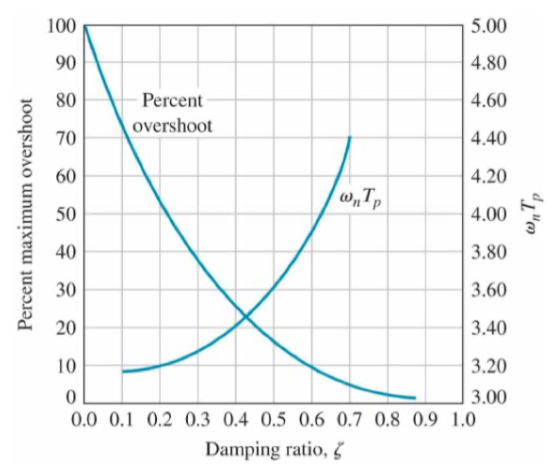

In [2]:
Image('PO.png')

$\omega_n$ can be calculcated from the settling time

In [3]:
zeta = 0.7
omega = 4/zeta

Calculate the loop function $L(s)$

In [4]:
K1, K2, s = sp.symbols("K_1, K_2, s")
G = 8/(s*(s+8))
L = reduce_feedback(K1*G, K2*s)
eq_disp('L(s)',L)

<IPython.core.display.Latex object>

Since the loop function is a second order system we can directly solve for $K_1$ and $K_2$ by comparing it to a second order system with the specified damping ratio and natural frequency.   
The target second order system is:

In [5]:
msd_sys = omega**2/(s*(s+2*zeta*omega))
msd_sys

32.6530612244898/(s*(s + 8.0))

$K_1$ and $K_2$ is then

In [6]:
K1, K2 = sp.solve(L-msd_sys, [K1, K2])[0]
eq_disp('K_1', K1)
eq_disp('K_2', K2)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# AP10.8

## Step 1: Find pole locations

We first translate the requirements into desired pole locations

In [7]:
PO = 20
Tr = 0.5
Ts = 1.2
Kv = 10

In [8]:
zeta, omega = sp.symbols('zeta, omega_n')
zeta = float(sp.solve(100*sp.exp(-zeta*sp.pi/sp.sqrt(1-zeta**2))-PO, zeta)[0])
omega = float(sp.solve((4/(omega*zeta)-Ts))[0])

In [9]:
zeta

0.4559498107691261

In [10]:
omega

7.310746171185917

In [11]:
p_goal = -complex(zeta*omega, -omega*np.sqrt(1-zeta**2))
p_goal

(-3.333333333333332+6.506604219437235j)

## Step 2: Uncompensated root locus

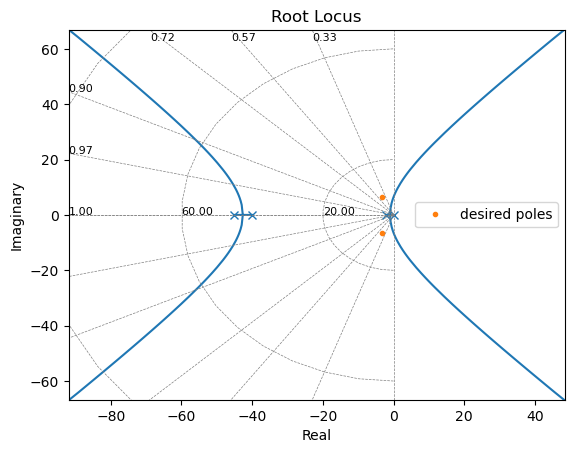

In [12]:
s = ct.tf('s')
G = 250/(s*(s+2)*(s+40)*(s+45))
rl = ct.rlocus(G)
handle = plt.plot([p_goal.real, p_goal.real], [p_goal.imag,-p_goal.imag], marker='.', label='desired poles', linestyle="None")
plt.legend(handles=handle)

We can see the desired poles can not be obtained without compensation

## Step 3: Placing zero directly under the desired root location

In [13]:
z = p_goal.real
z

-3.333333333333332

## Step 4: Use angle criteria to determine the pole location

In [14]:
p_angle = np.angle(p_goal-G.poles())
p_angle

array([0.15490742, 0.17562463, 1.77291815, 2.04423545])

In [15]:
angle_criterion = lambda x: np.pi - (sum(p_angle)+np.angle(p_goal - x) - np.angle(p_goal - z))

In [16]:
from scipy.optimize import fsolve
p = fsolve(angle_criterion, 0.5)[0]
p

-13.603875337607759

## Step 5: Determine the gain using magnitude criterion

In [17]:
P = G*(s-p_goal.real)/(s-p)

In [18]:
K = 1/abs(P(p_goal))
K

569.9604671830552

## Step 6: Check if requirements are met

Requirements were not met the first time due to the overshoot being too large, therefore the pole is moved further to the left and the gain is adjusted, after which the requirements were met.

In [19]:
z = p_goal.real 
p = p - 30
P = G*(s-z)/(s-p)

In [20]:
K = 1/abs(P(p_goal))
K

1912.3251691919936

{'RiseTime': 0.16929206244434314,
 'SettlingTime': 0.8818347730309815,
 'SettlingMin': 0.9003798074766735,
 'SettlingMax': 1.150162564932385,
 'Overshoot': 15.016256493238501,
 'Undershoot': 0,
 'Peak': 1.150162564932385,
 'PeakTime': 0.42954702411251244,
 'SteadyStateValue': 1.0}

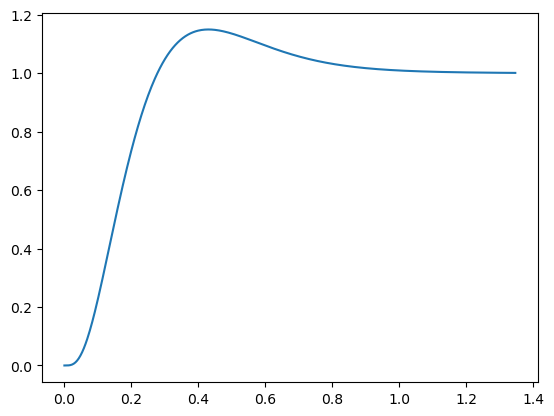

In [21]:
%matplotlib inline
T = ct.feedback(K*P)
plt.plot(*ct.step_response(T))
ct.step_info(T)

Velocity constant $K_v$ is given by

In [22]:
s_sym = sp.symbols('s')
Gs = 250/(s_sym*(s_sym+2)*(s_sym+40)*(s_sym+45))
Gcs = K*(s_sym-z)/(s_sym-p)
eq_disp('K_v', sp.N(sp.limit(s_sym*Gs*Gcs, s_sym, 0),3))

<IPython.core.display.Latex object>

# P10.32

## a)

In [23]:
Ksym, s = sp.symbols('K, s')
Kv = 100
Gc = Ksym
G = (s + 500)/(s*(s + 0.0325)*(s**2 + 2.57*s + 6667))

So the loop function is

In [24]:
L = Gc*G
eq_disp('L', L)

<IPython.core.display.Latex object>

In [25]:
K = float(sp.solve(sp.limit(sp.simplify(s*L), s, 0) - Kv, Ksym)[0])
eq_disp('K', K)

<IPython.core.display.Latex object>

Getting the phase and gain margin and plotting the bode plot

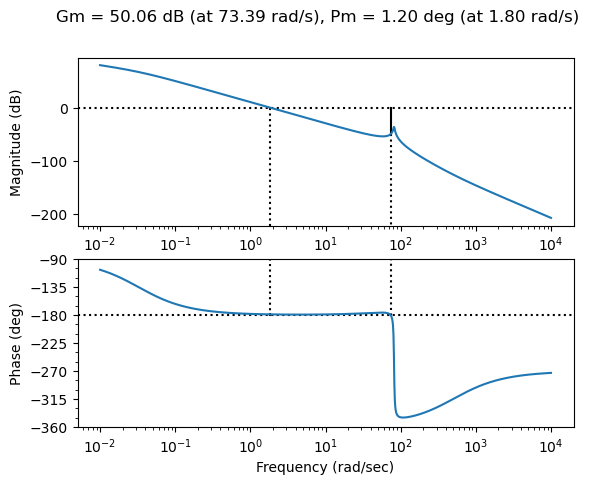

In [26]:
s = ct.tf('s')
Gc = K
G = (s + 500)/(s*(s + 0.0325)*(s**2 + 2.57*s + 6667))
L = Gc*G
gm, pm, wcg, wcp = ct.margin(L)
mag, phase, omega = ct.bode(L, dB=True, margins=True)

## b)

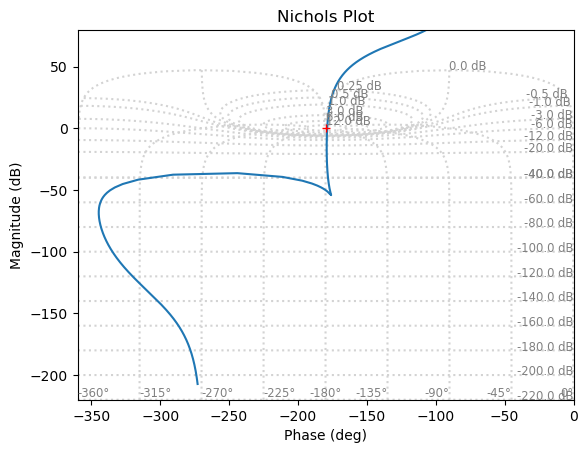

In [27]:
ct.nichols(L)

The Nichols plot does not display higher than 12 dB so $M_{p\omega}$ and $\omega_r$ cannot be read

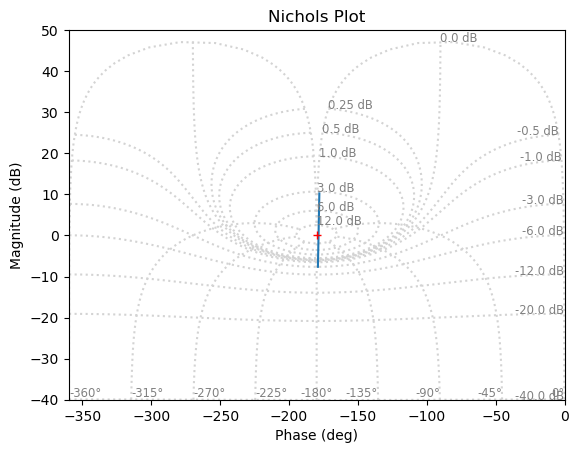

In [28]:
ct.nichols(L, omega=[1, 2.8])

So the bandwidth is (where it crosses -3 dB)

In [29]:
omega_B = 2.8
eq_disp('\omega_B', omega_B, 'rad/s')

<IPython.core.display.Latex object>

## c)

### 1. Evaluate the uncompensated system phase margin

In [30]:
eq_disp('\phi_{pm}', pm, 'deg')

<IPython.core.display.Latex object>

### 2. Determine necessary additional phase lead

In [31]:
phi_pm = 35
phi_m = phi_pm - pm
eq_disp('\phi_m', phi_m, 'deg')

<IPython.core.display.Latex object>

### 3. Evaluate $\alpha$

In [32]:
alphaSym = sp.symbols('alpha')
alpha = float(sp.solve(sp.sin(phi_m) - (alphaSym - 1)/(alphaSym + 1), alphaSym)[0])
eq_disp('\\alpha', alpha)

<IPython.core.display.Latex object>

In [33]:
float(-10*sp.log(alpha, 10))

-7.310584969802832

### 4. Determine the frequency $\omega_m$ where the uncompensated magnitude curve is equal to $-10 log(\alpha)$ dB

In [34]:
exp = float(-10*sp.log(alpha, 10))

for i, m in enumerate(20*np.log10(mag)):
    if m >= exp:
        index = i

omega_m = omega[index]
omega_m

2.7443433032283653

Plot the magnitude to check

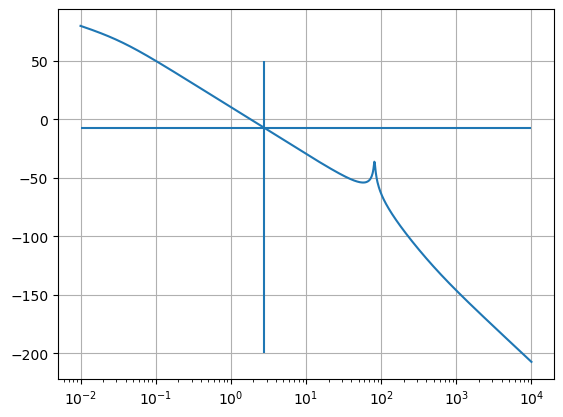

In [35]:
plt.plot(omega,20*np.log10(mag))
plt.hlines(float(-10*sp.log(alpha, 10)), 10**(-2), 10**(4))
plt.vlines(omega_m, -200, 50)
plt.xscale('log')
plt.grid()

### 5. Calculate the pole and zero

In [36]:
p = omega_m*np.sqrt(alpha)
z = p/alpha

### 6. Draw the compensated system frequency response and check phase margin 

Drawing the Bode plot and displaying the phase and gain margin

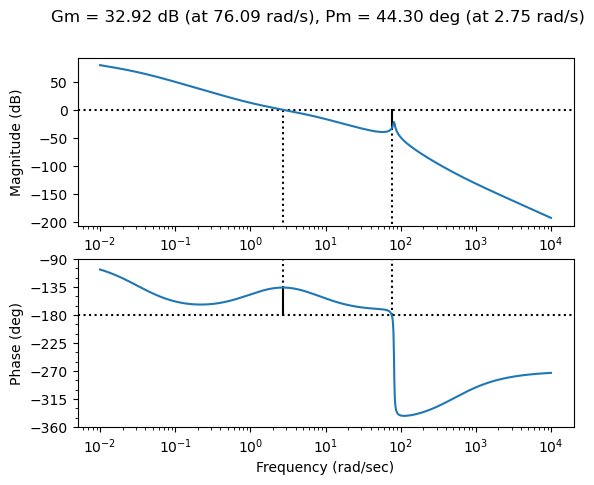

In [37]:
s = ct.tf('s')
G_comp = alpha*(s + z)/(s + p)
Lc = G_comp*L
mag_c, phase_c, omega_c = ct.bode(Lc, dB=True, margins=True)

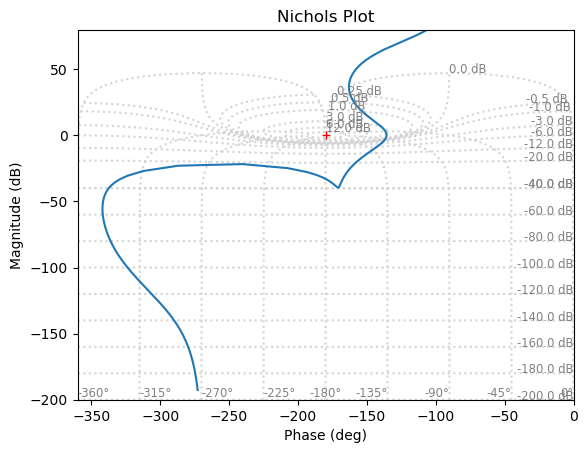

In [38]:
%matplotlib inline
ct.nichols(Lc)

In [39]:
%matplotlib qt
ct.nichols(Lc, omega=[4.5, 4.7])

From the nichols plot the resonant peak, resonant frequency and bandwidth is found

In [40]:
M_pw = 4
omega_r = 1.9
omega_B = 4.6
eq_disp('M_{p\\omega}', M_pw, 'dB')
eq_disp('\\omega_r', omega_r, 'rad/s')
eq_disp('\\omega_B', omega_B, 'rad/s')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# DP10.1
We will start with the lead compensator design to meet settling time and overshoot requirements, and then subsequently add the lag compensator to meet the error constant requirement

In [41]:
%matplotlib inline
s = ct.tf('s')
G = 20/(s*(s + 2))

## Step 1: Find pole locations

We first translate the requirements into desired pole locations. A safetyfactor is applied to the requirements to make sure they the design is within the boundaries

In [42]:
fs = 1.2  #safety factor
PO = 15/fs
Ts = 1/fs
Kv = 1/0.02

In [43]:
zeta, omega = sp.symbols('zeta, omega_n')
zeta = float(sp.solve(100*sp.exp(-zeta*sp.pi/sp.sqrt(1-zeta**2))-PO, zeta)[0])
omega = float(sp.solve((4/(omega*zeta)-Ts))[0])
eq_disp('\zeta', zeta)
eq_disp('\omega', omega)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Desired pole location

In [44]:
p_goal = -complex(zeta*omega, -omega*np.sqrt(1-zeta**2))
p_goal

(-4.800000000000003+7.251776226923514j)

## Step 2: Uncompensated root locus

(-8.0, 8.0)

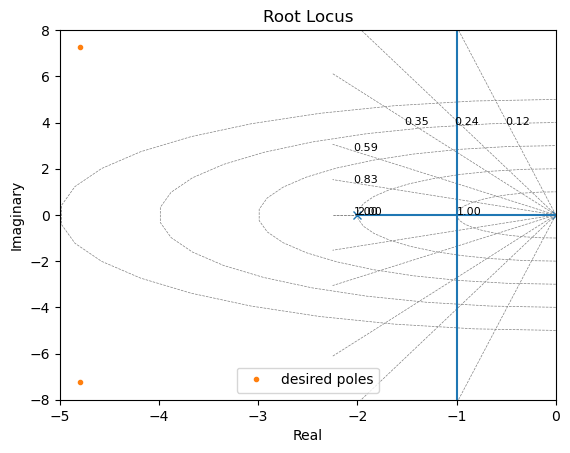

In [45]:
rl = ct.rlocus(G)
handle = plt.plot([p_goal.real, p_goal.real], [p_goal.imag,-p_goal.imag], marker='.', label='desired poles', linestyle="None")
plt.legend(handles=handle)
plt.xlim(-5, 0)
plt.ylim(-8, 8)

We can see the desired poles can not be obtained without compensation

## Step 3: We cancel the minimum valued system pole with our controller zero

In [46]:
z = float(np.min(G.poles()))

/var/folders/mr/8dv953yx4cg4k1jrzprcqlzw0000gn/T/ipykernel_10597/51982335.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  z = float(np.min(G.poles()))


## Step 4: Use angle criteria to determine the pole location

Angles contributed by system poles

In [47]:
p_angle = np.angle(p_goal-G.poles())

Angle criterion equation

In [48]:
angle_criterion = lambda x: np.pi - (sum(p_angle)+np.angle(p_goal - x) - np.angle(p_goal - z))

Solve for pole location

In [49]:
from scipy.optimize import fsolve
p = fsolve(angle_criterion, 0.5)[0]
p

-9.600000000000005

## Step 5: Determine the gain using magnitude criterion

In [50]:
P = G*(s-z)/(s-p)

In [51]:
K = 1/abs(P(p_goal))
K

3.7814129222686534

## Step 6: Plot the result and verify that specifications are met

{'RiseTime': 0.20351130872422116,
 'SettlingTime': 0.6832165364313139,
 'SettlingMin': 0.912851576803955,
 'SettlingMax': 1.1249611907772497,
 'Overshoot': 12.496119077724966,
 'Undershoot': 0,
 'Peak': 1.1249611907772497,
 'PeakTime': 0.43609566155190244,
 'SteadyStateValue': 1.0}

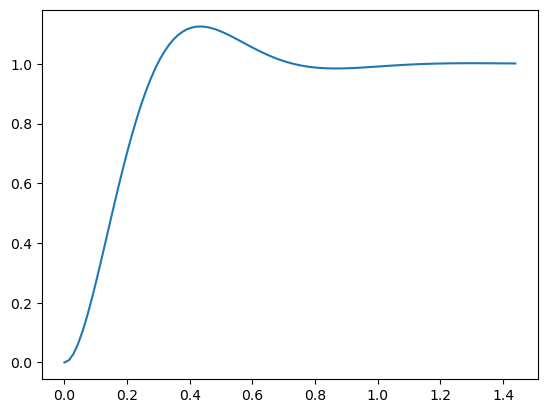

In [52]:
Glead = K*(s-z)/(s-p)
T = ct.feedback(Glead*G)
plt.plot(*ct.step_response(T))
ct.step_info(T)

## Lag compensator design

First we calculcate the value of $\alpha$ needed to satisfy the steady state requirement

In [53]:
s_sym = sp.symbols('s')
Gs = 20/(s_sym*(s_sym + 2))
Gcs = K*(s_sym-z)/(s_sym-p)
Kv_current = float(sp.limit(s_sym*Gs*Gcs, s_sym, 0))
eq_disp('K_v', sp.N(Kv_current,3))

<IPython.core.display.Latex object>

In [54]:
alpha = Kv/Kv_current
eq_disp('\\alpha', alpha)

<IPython.core.display.Latex object>

We set the zero position to 0.1 and calculate the pole position from $\alpha$

In [55]:
z_lag = 0.1
p_lag = z_lag/alpha
Glag = (s+z_lag)/(s+p_lag)

We can now test to see if we meet the requirements

{'RiseTime': 0.20321184180929006,
 'SettlingTime': 0.7257565778903217,
 'SettlingMin': 0.9190036694691347,
 'SettlingMax': 1.1382098574468962,
 'Overshoot': 13.820985744689619,
 'Undershoot': 0,
 'Peak': 1.1382098574468962,
 'PeakTime': 0.435453946734193,
 'SteadyStateValue': 1.0}

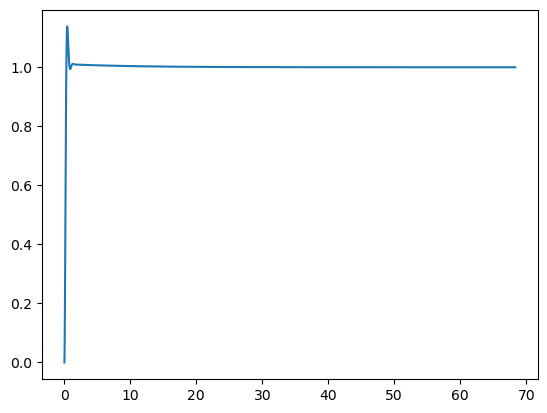

In [56]:
T = ct.feedback(Glead*Glag*G)
plt.plot(*ct.step_response(T))
ct.step_info(T)

Velocity constant $K_v$ is given by

In [57]:
s_sym = sp.symbols('s')
Gs = 20/(s_sym*(s_sym + 2))
Gcs = K*(s_sym-z)/(s_sym-p)*(s_sym-z_lag)/(s_sym-p_lag)
Kv_current = float(sp.limit(s_sym*Gs*Gcs, s_sym, 0))
eq_disp('K_v', sp.N(Kv_current,3))

<IPython.core.display.Latex object>

Giving a steady state error of

In [58]:
eq_disp('e_{ss}', sp.N(1/Kv_current,3))

<IPython.core.display.Latex object>

# DP10.10

In [59]:
G = (s + 1.59)/(s*(s + 3.7)*(s**2 + 2.4*s + 0.43))
G

TransferFunction(array([1.  , 1.59]), array([1.   , 6.1  , 9.31 , 1.591, 0.   ]))

The requirements are:
1. $20log|L|>20$ dB at $\\omega \leq 0.01 rad/s$
2. $20log|L|<20$ dB at $\\omega \leq 10 rad/s$

## The uncompensated frequency response

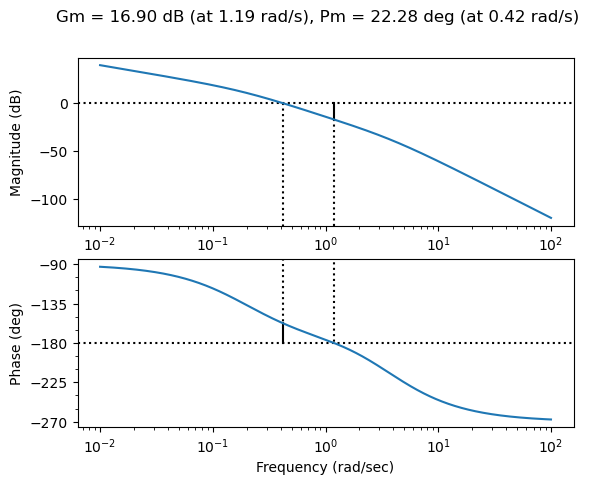

In [60]:
%matplotlib inline
mag, phase, omega = ct.bode(G, dB=True, margins=True)
omega20 = 0.01
omegam20 = 10

## The compensated frequency response

A zero is placed at low frequency to increase the magnitude slope, a gain increases the magnitude both to satisfy the first requirement. A pole is placed at higher frequency to decrease the slope to meet the second requirement. The values are found by trial and error

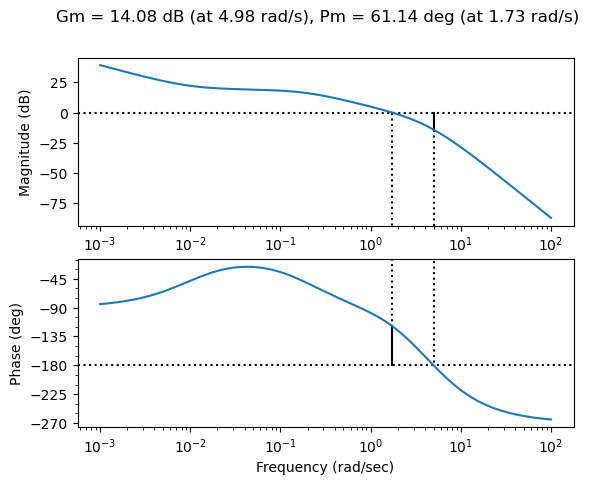

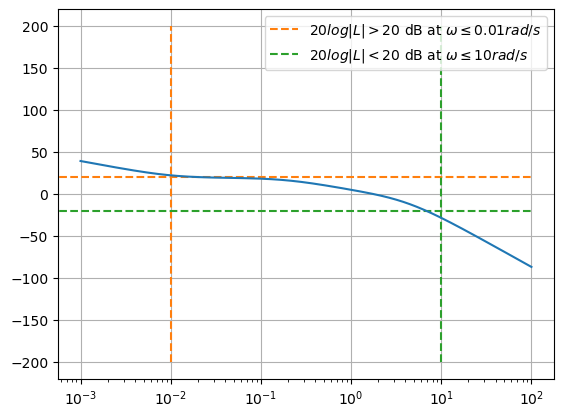

In [61]:
Gc = 45*(s + 0.01)/(s + 5)
L = Gc*G
mag, phase, omega = ct.bode(L, dB=True, margins=True)


fig, (ax) = plt.subplots()
ax.plot(omega,20*np.log10(mag))

# mag=20
plt.hlines(20, 0, 10**(2), linestyle='--', color='tab:orange', label='$20log|L|>20$ dB at $\\omega \leq 0.01 rad/s$')
plt.vlines(omega20, -200, 200, linestyle='--', color='tab:orange')

# mag=-20
plt.hlines(-20, 0, 10**(2), linestyle='--', color='tab:green', label='$20log|L|<20$ dB at $\\omega \leq 10 rad/s$')
plt.vlines(omegam20, -200, 200, linestyle='--', color='tab:green')

plt.legend()
ax.set_xscale('log')
ax.grid()


The plot shows that the design meets the two requirements.

High gain magnitude is wanted at low frequencies to decrease the sensitivity to disturbances and to decrease the sensitivity to plant changes over time. Low gain magnitude is wanted at high frequencies to decrease the sensitivity to noise signals.